In [12]:
import collections

import os
from pathlib import Path
import sys
import hashlib

import requests
import re

sys.path.append(str(Path(os.getcwd()).parent))


import my_helper as helper

In [7]:
DATA_URL = 'https://d2l-data.s3-accelerate.amazonaws.com/'

def download(url, folder='../data', sha1_hash=None):
    """Download a file to folder and return the local filepath."""
    if not url.startswith('http'):
        # For back compatibility
        url, sha1_hash = DATA_HUB[url]
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

# Reading The Dataset

In [39]:
class TimeMachine(helper.DataModule):

    def _download(self):
        fname = download(DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
        
    def _preprocess(self,text):
        return re.sub('[^A-Za-z]+'," ",text).lower()
    
    def _tokenize(self,text):
        return list(text)
    
    def build(self,raw_text,vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None :vocab = Vocab(tokens)
        corpus = [vocab(token) for token in tokens]
        return corpus ,vocab

In [40]:
data = TimeMachine()
raw_text = data._download()

In [41]:
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [42]:
text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

# Tokenization

Tokenization as the sequence of character.

In [43]:
tokens = data._tokenize(text)
",".join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

# Vocabulary

Still token are string , but the model take the input in format of numbers. We have to convert the token into string.

In [44]:
class Vocab:
    def __init__(self,tokens=[],min_freq=0,reserved_words=[]) -> None:
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0],list):
            tokens = [token 
                      for line in tokens
                      for token in line]
        # Count the token  frequency
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(),key=lambda x:x[1],
                                  reverse=True)
        
        # list of unique token
        self.idx_to_token = list(sorted(
            set(['<unk>']+reserved_words+
                [token for token,freq in self.token_freqs if freq >= min_freq])
            ))
        self.token_to_idx = {token:idx
                             for idx,token in enumerate(self.idx_to_token)}
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self,tokens):
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        if hasattr(indices,"__len__") and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):
        return self.token_to_idx['<unk>']
                                 
        

In [45]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [49]:
class TimeMachine(helper.DataModule):

    def _download(self):
        fname = download(DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
        
    def _preprocess(self,text):
        return re.sub('[^A-Za-z]+'," ",text).lower()
    
    def _tokenize(self,text):
        return list(text)
    
    def build(self,raw_text,vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None :vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus ,vocab

In [51]:
data = TimeMachine()
raw_text = data._download()

In [52]:
corpus,vocab = data.build(raw_text)

In [53]:
len(corpus),len(vocab)

(173428, 28)

In [54]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

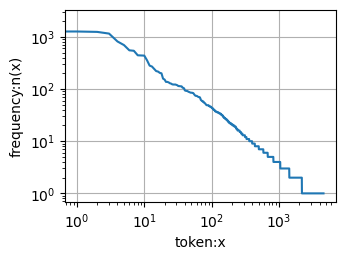

In [55]:
freq = [freq for token,freq in vocab.token_freqs]
helper.plot(freq,xlabel="token:x",ylabel="frequency:n(x)",xscale="log",yscale="log")

In [56]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]


[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [57]:
trigram_tokens = ['--'.join(triple) for triple in zip(
words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

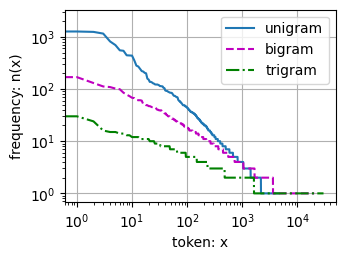

In [59]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
helper.plot([freq, bigram_freqs, trigram_freqs], xlabel='token: x',
ylabel='frequency: n(x)', xscale='log', yscale='log',
legend=['unigram', 'bigram', 'trigram'])